# <font color='red'>1. Préparation de l'environnement </font>

Ci-dessous nous réalisons les imports de librairie nécessaire à notre travail et égal définir les précaustion préalables.

In [12]:
# imports
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from statistics import mean
from time import *
from pandas.plotting import scatter_matrix
import seaborn as sbn
from sklearn.preprocessing import OneHotEncoder

# stabilité du notebook d'une exécution à l'autre
random=np.random.default_rng(42) 

# jolies figures directement dans le notebook
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# <font color='red'>2. Création des DataFrames </font>

Nous allons tout d'abord commencer par importer les CSV fournis dans le projet afin de réaliser la création des dataframes correspondant.

In [3]:
def load_data(fileName):
    csv_path = os.path.join('../data', fileName)
    df = pd.read_csv(csv_path)
    return df

In [4]:
employee_survey_data = load_data('employee_survey_data.csv')
manager_survey_data = load_data('manager_survey_data.csv')
in_time = load_data('in_time.csv')
out_time = load_data('out_time.csv')
general_data = load_data('general_data.csv')

# <font color='red'>3. Choix des données </font>

## <font color='green'>3.1 Éthique </font>

Dans le cas de notre modèle et de l'utilisation de nos données il est important de déterminer étiquement la conservation de certaines données ou non. 

Pour cela nous avons procédé à un brainstorming et à une lecture des recommendations de la CNIL pour conserver uniquement les données nécessaires et ne prétant pas à une possible discrimination.

Voici la liste des données que nous ne souhaitons pas conserver pour notre modèle :

- **L’âge des employés (Age) :** Nous souhaitons rester dans la plus grande neutralité possible.Effectivement, l’âge ne doit pas nous permettre de définir si une personne est plus à même de quitter l’entreprise ou non. 
<br>

- **Le genre des employés (Gender) :** Le genre est une donnée non pertinante sur les critères qui pousserai à un turnover. Cette donnée pourrait être discrimante 
<br>

- **Le statut marital (MaritalStatus) :** Cette donnée ne nous permetrai pas d’interpreter des critères cohérent concernant les Turn-over dans l’entrprise. Ce serai une surinterpretation des données fournis.

In [5]:
#remove the columns for ethic
general_dataset = general_data.copy() #copy the dataframe to avoid changing the original one
general_dataset.drop("Age", axis=1, inplace=True) 
general_dataset.drop("Gender", axis=1, inplace=True)
general_dataset.drop("MaritalStatus", axis=1, inplace=True)

## <font color='green'>3.2 Logique </font>

Il est également nécessaire de déterminer d'une manière logique les données utile à conserver ou non. 

Pour cela il suffit d'isoler dans un premier temps les colonnes de la table ***General_data***  ou le champs de valeur est égal à 1, c'est à dire que chaque données est la même.

Pour cela il suffit d'executer cette fonction afin de déterminer les champs répondant à cette condition :

In [6]:
for col in general_data.columns:
    value = general_data[col].nunique()
    value_of = general_data[col].unique()
    if value == 1:
        print(col)
        print(value_of)

EmployeeCount
[1]
Over18
['Y']
StandardHours
[8]


On constate alors que :

- **EmployeeCount :** Cette colonne correspond à la présence ou non d'un employé dans l'entreprise dans les effectifs en 2015, on constate que chaque ligne du tableau est à 1 cela signifie donc que tous les employés présent dans les données était dans l'entreprise en 2015, il n'est donc pas intéressant de conserver cette donnée.
<br>

- **Over18 :** Cette colonne indique si l'age de l'employé est supérieure ou non à 18 ans, on constate que chaque ligne du tableau est à la valeure "Y" cela signifie donc que en 2015 chaque employé était majeur, il n'est donc pas intéressant de conserver cette donnée. 
<br>

- **StandardHours :** Cette colonne spécifie le nombre d'heure inscrite sur le contrat de l'employé, chaque ligne étant positionnée à 8h on en déduit que tous les employés disposait du même type de contrat en 2015. Il n'est donc pas intéressant de conserver cette donnée.

<div class="alert alert-block alert-info">
<b>Info:</b> Cette étude à également été effectuée sur les autres tables mais aucune valeur unique est apparue, nous conserverons alors toutes les données de celles-ci.
</div>


In [7]:
# remove the non revelent columns
general_dataset.drop("Over18", axis=1, inplace=True)
general_dataset.drop("EmployeeCount", axis=1, inplace=True)
general_dataset.drop("StandardHours", axis=1, inplace=True)

## <font color='green'>3.3 Conclusion </font>

Après avoir selectionné les données à conserver en fonction de différents facteurs voici une liste exhaustive de celles conservées pour la réalisation de notre modèle :

###  <font color='blue'> General_data </font>

- **Attrition :** L'objet de notre étude, est-ce que l'employé a quitté l'entreprise durant l'année 2016 ?
<br>

- **BusinessTravel :** A quel fréquence l'employé a été amené à se déplacer dans le cadre de son travail en 2015 ? (Non-Travel = jamais, Travel_Rarely= rarement, Travel_Frequently = fréquemment)
<br>

- **DistanceFromHome :** Distance en km entre le logement de l'employé et l'entreprise.
<br>

- **Education : Niveau d'étude :** 1=Avant College (équivalent niveau Bac), 2=College (équivalent Bac+2), 3=Bachelor (Bac+3), 4=Master (Bac+5) et 5=PhD (Thèse de doctorat).
<br>

- **EducationField :** Domaine d'étude, matière principale
<br>

- **EmployeeId :** l'identifiant d'un employé
<br>

- **JobLevel :** Niveau hiérarchique dans l'entreprise de 1 à 5
<br>

- **JobRole :** Métier dans l'entreprise
<br>

- **MonthlyIncome :** Salaire brut en roupies par mois
<br>

- **NumCompaniesWorked :** Nombre d'entreprises pour lequel le salarié a travaillé avant de rejoindre HumanForYou.
<br>

- **PercentSalaryHike :** % d'augmentation du salaire en 2015.
<br>

- **StockOptionLevel :** Niveau d'investissement en actions de l'entreprise par le salarié.
<br>

- **TotalWorkingYears :** Nombre d'années d'expérience en entreprise du salarié pour le même type de poste.
<br>

- **TrainingTimesLastYear :** Nombre de jours de formation en 2015
<br>

- **YearsAtCompany :** Ancienneté dans l'entreprise
<br>

- **YearsSinceLastPromotion :** Nombre d'années depuis la dernière augmentation individuelle
<br>

- **YearsWithCurrentManager :** Nombre d'années de collaboration sous la responsabilité du manager actuel de l'employé.

###  <font color='blue'> Employee_survey_data </font>

- **L'environnement de travail :** : noté 1 ("Faible"), 2 ("Moyen"), 3 ("Élevé") ou 4 ("Très élevé") : EnvironmentSatisfaction
<br>

- **Son travail :** noté de 1 à 4 comme précédemment : JobSatisfaction
<br>

- **Son équilibre entre vie professionnelle et vie privée :** noté 1 ("Mauvais"), 2 ("Satisfaisant"), 3 ("Très satisfaisant") ou 4 ("Excellent") : WorkLifeBalance

###  <font color='blue'> Manager_survey_data </font>

- **Une évaluation de son implication dans son travail :** notée 1 ('Faible'), 2 ("Moyenne"), 3 ("Importante") ou 4 ("Très importante") : JobInvolvement
<br>

- **Une évaluation de son niveau de performance annuel pour l'entreprise :** notée 1 ("Faible"), 2 ("Bon"), 3 ("Excellent") ou 4 ("Au delà des attentes") : PerformanceRating

###  <font color='blue'> In_Time et Out_Time </font>

Nous allons conserver toutes les données de badgeuse d'entrée et de sortie afin d'effectuer différents statistiques sur ces données.

# <font color='red'>4. Encodage </font>

## <font color='green'>4.1 Encodage binaire de l'attribut ***Attrition*** </font>
On convertit les données de l'attribut Attrition afin de rendre l'étude plus pertinente dans notre modéle, les valeurs 'Yes' et 'No' deviennent respectivement des 1 et des 0.

In [13]:
general_dataset['Attrition'] = general_dataset['Attrition'].map({'Yes': 1, 'No':0}) # convertir la colonne Attrition en 0 et 1

fir_column = general_dataset.pop('Attrition') # retirer la colonne Attrition
general_dataset.insert(0 ,'Attrition', fir_column) # la remettre en première colonne

## <font color='green'>4.2 One-Hot Encoding </font>
Nous allons créer des variables supplémentaires pour représenter chacun des catégories.
**BusinessTravel**, **Department**, **EducationField**, **JobRole**

In [14]:
onehot_encoder = OneHotEncoder(sparse=False) # sparse=False pour obtenir un tableau numpy (et non une matrice creuse)
data_encoded = onehot_encoder.fit_transform(general_dataset[['BusinessTravel', 'Department', 'EducationField', 'JobRole']])

def result_onehot(cat_one):
    tab = []
    for tableau in cat_one:
        for tableau2 in tableau:
            tab.append(tableau2)
    return tab

ids = [ i for i in range (1, (len(data_encoded)+1))]
df = pd.DataFrame(data=data_encoded, dtype=np.int8, columns=result_onehot(onehot_encoder.categories_))
df['Employee_id'] = ids
df

C:\Users\Nico\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Non-Travel,Travel_Frequently,Travel_Rarely,Human Resources,Research & Development,Sales,Human Resources,Life Sciences,Marketing,Medical,...,Healthcare Representative,Human Resources,Laboratory Technician,Manager,Manufacturing Director,Research Director,Research Scientist,Sales Executive,Sales Representative,Employee_id
0,0,0,1,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
1,0,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,2
2,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,3
3,1,0,0,0,1,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,4
4,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,4406
4406,0,0,1,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,4407
4407,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,4408
4408,0,0,1,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,4409


# <font color='red'>5. Echantiollonage stratifié</font>

Nous désirons effectuer un échantillonage respectant les proportions de représentation des différentes catégories de salaire. 

Il est plus intéressant de catégoriser ces valeurs de salaire afin de les utiliser dans notre modèle, il n'est pas réelement pertinent d'exploiter les données bruts telles quelles.

Dans un premier temps nous allons chercher à déterminer le salaire maximum afin d'en déduire le nombre de catégorie idéal.

In [10]:
general_dataset["MonthlyIncome"].describe()

count      4410.000000
mean      65029.312925
std       47068.888559
min       10090.000000
25%       29110.000000
50%       49190.000000
75%       83800.000000
max      199990.000000
Name: MonthlyIncome, dtype: float64

On constate que la valeur maximale est d'environ ***200 000*** il sera donc intéressant de diviser cette catégorie en 10 parties. 

Nous devrons donc diviser nos valeurs par ***20 000***

<AxesSubplot: >

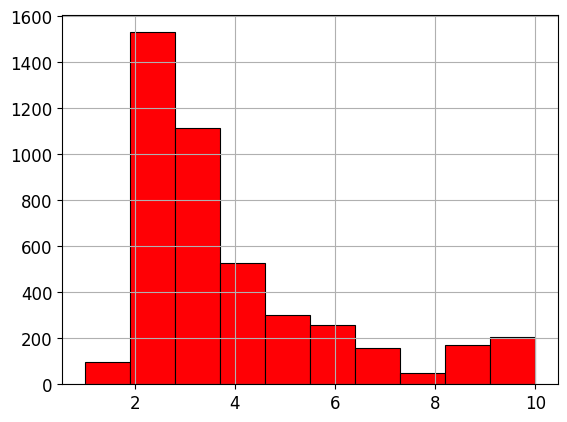

In [11]:
general_dataset["MonthlyIncome_cat"] = np.ceil(general_dataset["MonthlyIncome"]/20000)

general_dataset["MonthlyIncome_cat"].hist(facecolor = '#ff0005', edgecolor='#000000', linewidth=0.8, bins=10)

Maintenant que nous avons créé notre nouvelle catégorie de salaire il n'est plus nécessaire de conserver l'ancinne colonne nommée **"MonthlyIncome"**.

Il suffit alors d'executer un **.drop()**

In [12]:
general_dataset.drop("MonthlyIncome", axis=1, inplace=True)
general_dataset.head(3)

,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,JobLevel,JobRole,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,MonthlyIncome_cat
0,0,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Healthcare Representative,1.0,11,0,1.0,6,1,0,0,7.0
1,1,Travel_Frequently,Research & Development,10,1,Life Sciences,2,1,Research Scientist,0.0,23,1,6.0,3,5,1,4,3.0
2,0,Travel_Frequently,Research & Development,17,4,Other,3,4,Sales Executive,1.0,15,3,5.0,2,5,0,3,10.0


# <font color='red'>6. Calcul de moyennes sur les DataFrame In_Time et Out_Time</font>

## <font color='green'>6.1 Gestion des NaN</font>

De nombreuses données sont manquantes parmis les horaires et sont représentées par la veleur **"NaN"**. 

Nous faisons le choix de supprimer une colonne contenant plus de 50% de données manquantes. Pour les autres données manquantes, nous les remplaçons par la date Unix qui correspond à une valeur nul en format date afin que ces données n'aient pas d'influence sur nos calculs.

In [13]:
#prepare time dataset
def dropNan(dataset):

    data = dataset.copy()
    colNames = [col for col in data.columns]

    percent= [round(100-((data[col].count()/len(data.index))*100),2) for col in data.columns]
    indexes = [index for index, value in enumerate(percent) if value > 50]

    for i in indexes:
        data.drop(colNames[i], axis=1, inplace=True)
        
    data.fillna("1970-01-01 00:00:00", inplace=True)
    
    return data

In [14]:
inTime_prep = dropNan(in_time)
outTime_prep = dropNan(out_time)
inTime_prep.head(3)

,Unnamed: 0,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,2015-01-15,...,2015-12-17,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,2015-01-02 09:43:45,2015-01-05 10:08:48,2015-01-06 09:54:26,2015-01-07 09:34:31,2015-01-08 09:51:09,2015-01-09 10:09:25,2015-01-12 09:42:53,2015-01-13 10:13:06,2015-01-15 10:01:24,...,1970-01-01 00:00:00,1970-01-01 00:00:00,2015-12-21 09:55:29,2015-12-22 10:04:06,2015-12-23 10:14:27,2015-12-24 10:11:35,2015-12-28 10:13:41,2015-12-29 10:03:36,2015-12-30 09:54:12,2015-12-31 10:12:44
1,2,2015-01-02 10:15:44,2015-01-05 10:21:05,1970-01-01 00:00:00,2015-01-07 09:45:17,2015-01-08 10:09:04,2015-01-09 09:43:26,2015-01-12 10:00:07,2015-01-13 10:43:29,2015-01-15 09:37:57,...,2015-12-17 09:15:08,2015-12-18 10:37:17,2015-12-21 09:49:02,2015-12-22 10:33:51,2015-12-23 10:12:10,1970-01-01 00:00:00,2015-12-28 09:31:45,2015-12-29 09:55:49,2015-12-30 10:32:25,2015-12-31 09:27:20
2,3,2015-01-02 10:17:41,2015-01-05 09:50:50,2015-01-06 10:14:13,2015-01-07 09:47:27,2015-01-08 10:03:40,2015-01-09 10:05:49,2015-01-12 10:03:47,2015-01-13 10:21:26,2015-01-15 09:55:11,...,2015-12-17 09:53:17,2015-12-18 10:15:14,2015-12-21 10:10:28,2015-12-22 09:44:44,2015-12-23 10:15:54,2015-12-24 10:07:26,2015-12-28 09:42:05,2015-12-29 09:43:36,2015-12-30 09:34:05,2015-12-31 10:28:39


On constate bien que notre tableau ne contient plus aucune valeure NaN et que celles-ci ont été remplacées par la valeure UNIX ***"1970-01-01 00:00:00"***

## <font color='green'>6.2 Calculs des moyennes</font>

Dans notre modèle il n'est pas pertient d'utiliser les valeurs d'heures d'entrée et de sortie telle quelle, l'utilisation de celles -ci ne permettrai pas de faire de corélation entre plusieurs données.

Nous avons donc décider de réaliser 3 moyennes différentes :

- **Average_Worktime :** Correspond au temps de travail moyen de chaque employé pour l'année 2015
<br>

- **Average_In_Time :** Correspond aux heures moyennes d'arrivés par employé pour l'année 2015
<br>

- **Average_Out_Time :** Correspond aux heures moyennes de départs par employé pour l'année 2015

In [15]:
def sec(date):
    getlast = ((str(date))[-8:]).replace(":", "")
    time = (int(getlast[4:6])) + ((int(getlast[2:4])) * 60) + (int(getlast[0:2])) * 3600
    return time

def average_In_Out_Time(time):
    tabs = []
    for row in range(0, len(time)):
        means = [sec(dt.datetime.strptime(time.iloc[row, col], "%Y-%m-%d %H:%M:%S")) for col in range(1, len(time.columns))]
        means_convert = round(((int((round(mean(means), 0)))) / 3600),2)
        tabs += [means_convert]
    return tabs
    
def average_worktime(out_time, in_time) :
    tab = []
    for lines in range(0, len(out_time)):
        worktime = [(((dt.datetime.strptime(out_time.iloc[lines,col], "%Y-%m-%d %H:%M:%S")) - (dt.datetime.strptime(in_time.iloc[lines,col], "%Y-%m-%d %H:%M:%S"))).total_seconds()) for col in range(1, len(out_time.columns))]
        worktime_convert = round(((int((round(mean(worktime), 0)))) / 3600),2)
        tab += [worktime_convert]
    return tab

In [16]:
d = {'EmployeeID': inTime_prep.iloc[:, 0], 'Average_Worktime': average_worktime(outTime_prep, inTime_prep), 'Average_In_Time': average_In_Out_Time(inTime_prep), 'Average_Out_Time': average_In_Out_Time(outTime_prep)}
wortime_employee = pd.DataFrame(data=d)
wortime_employee.head(3)

,EmployeeID,Average_Worktime,Average_In_Time,Average_Out_Time
0,1,6.87,9.32,16.19
1,2,7.32,9.47,16.78
2,3,6.82,9.74,16.56


On peut alors observer notre DataFrame ci-dessus avec les différentes moyennes.

# <font color='red'>7. Fusion des tables</font>
Nous allons fusionner les dataframes selon l'id de l'employé pour inclure les evaluations d'impliquation, les évaluations de niveaux de performance et les données concernant les horaires.

In [17]:
#merge the dataframes
survey_dataset = pd.merge(employee_survey_data, manager_survey_data, on='EmployeeID')
dataset_with_survey = pd.merge(general_dataset, survey_dataset, on='EmployeeID')
Dataset = pd.merge(dataset_with_survey, wortime_employee, on='EmployeeID')
Dataset.head(3)

,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,JobLevel,JobRole,NumCompaniesWorked,...,YearsWithCurrManager,MonthlyIncome_cat,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,Average_Worktime,Average_In_Time,Average_Out_Time
0,0,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Healthcare Representative,1.0,...,0,7.0,3.0,4.0,2.0,3,3,6.87,9.32,16.19
1,1,Travel_Frequently,Research & Development,10,1,Life Sciences,2,1,Research Scientist,0.0,...,4,3.0,3.0,2.0,4.0,2,4,7.32,9.47,16.78
2,0,Travel_Frequently,Research & Development,17,4,Other,3,4,Sales Executive,1.0,...,3,10.0,2.0,2.0,1.0,3,3,6.82,9.74,16.56


# <font color='red'>8. Nettoyage des données</font>

Nous allons supprimer les valeurs manquantes.
Nous constatons alors qu'il y a des valeurs manquantes pour 110 employés.

In [18]:
sample_incomplete_rows = Dataset[Dataset.isnull().any(axis=1)]
len(sample_incomplete_rows.index)

110

Cela correspond à moins de 3% de nos valeurs.

Nous faisons donc le choix de supprimer les lignes contenant des valeurs manquantes.

In [19]:
(len(sample_incomplete_rows.index)/len(Dataset.index))*100

2.494331065759637

In [20]:
Dataset.dropna(inplace=True)
Dataset.head(3)

,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,JobLevel,JobRole,NumCompaniesWorked,...,YearsWithCurrManager,MonthlyIncome_cat,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,Average_Worktime,Average_In_Time,Average_Out_Time
0,0,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Healthcare Representative,1.0,...,0,7.0,3.0,4.0,2.0,3,3,6.87,9.32,16.19
1,1,Travel_Frequently,Research & Development,10,1,Life Sciences,2,1,Research Scientist,0.0,...,4,3.0,3.0,2.0,4.0,2,4,7.32,9.47,16.78
2,0,Travel_Frequently,Research & Development,17,4,Other,3,4,Sales Executive,1.0,...,3,10.0,2.0,2.0,1.0,3,3,6.82,9.74,16.56


# <font color='red'>9. Correlation</font>

In [21]:
corrmatrix = Dataset.corr()
corrmatrix['Attrition']

C:\Users\oscar\AppData\Local\Temp\ipykernel_12388\4077177633.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmatrix = Dataset.corr()


Attrition                  1.000000
DistanceFromHome          -0.008314
Education                 -0.015237
EmployeeID                -0.001707
JobLevel                  -0.014587
NumCompaniesWorked         0.043911
PercentSalaryHike          0.034425
StockOptionLevel          -0.007971
TotalWorkingYears         -0.168637
TrainingTimesLastYear     -0.046239
YearsAtCompany            -0.133612
YearsSinceLastPromotion   -0.029931
YearsWithCurrManager      -0.155420
MonthlyIncome_cat         -0.034361
EnvironmentSatisfaction   -0.103485
JobSatisfaction           -0.103098
WorkLifeBalance           -0.059817
JobInvolvement            -0.014705
PerformanceRating          0.026262
Average_Worktime           0.195118
Average_In_Time            0.039340
Average_Out_Time           0.188202
Name: Attrition, dtype: float64

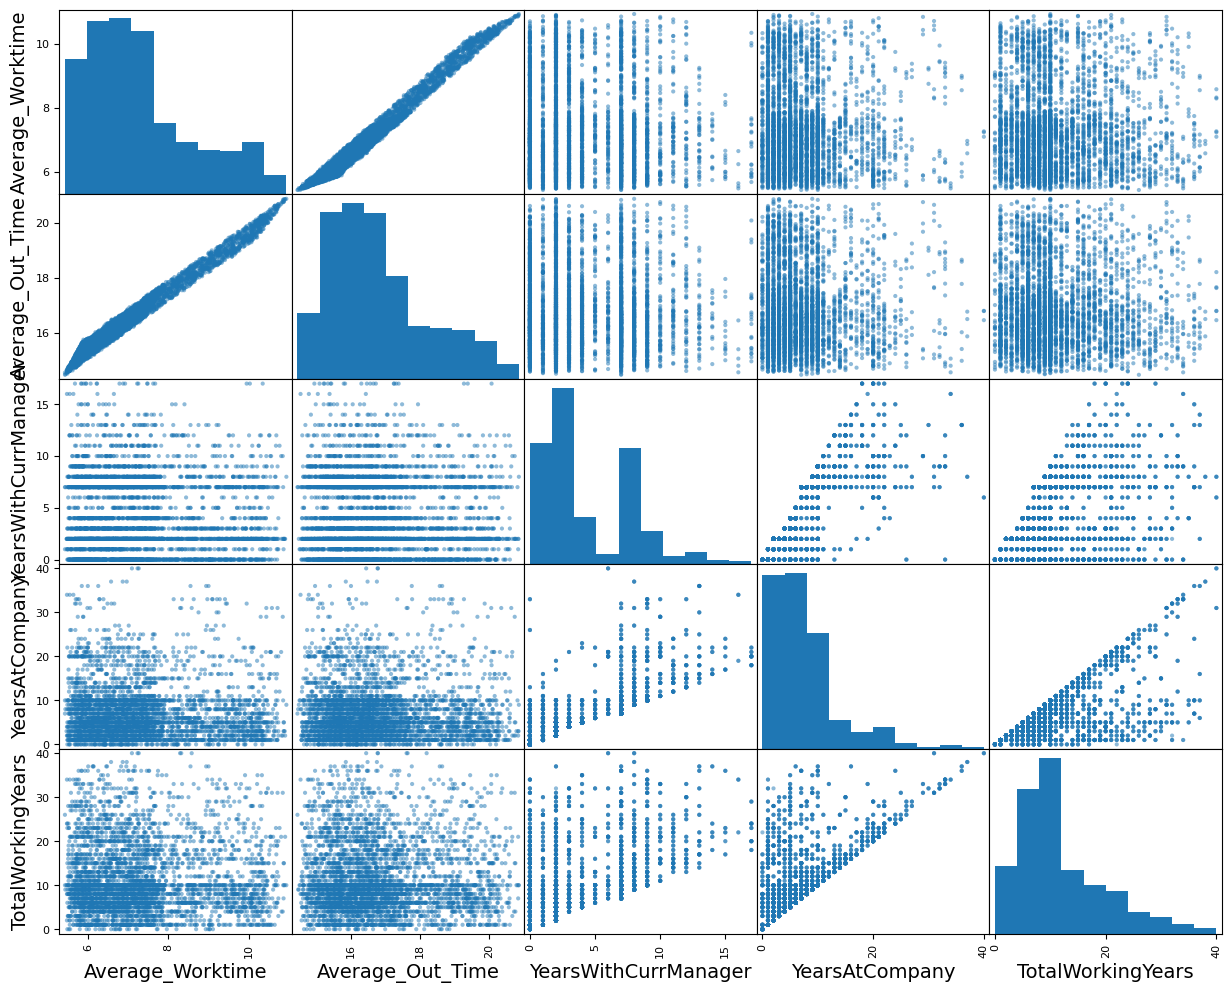

In [22]:
attributes = ["Average_Worktime", "Average_Out_Time", "YearsWithCurrManager", "YearsAtCompany", "TotalWorkingYears"]
scat_matrix = scatter_matrix(Dataset[attributes], figsize=(15, 12))

16.162790697674417


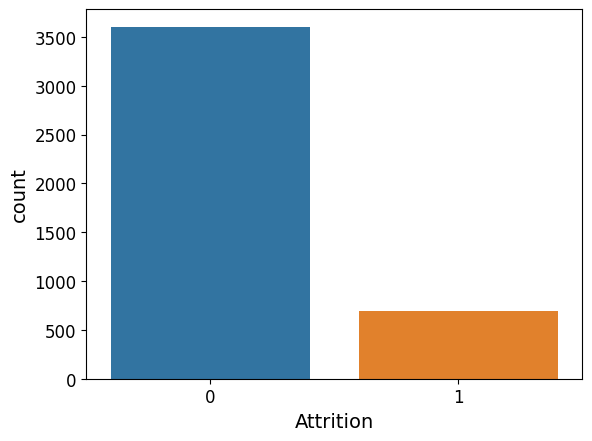

In [33]:
percent = ((Dataset['Attrition'] == 1).sum() / Dataset['Attrition'].shape[0]) * 100
print(percent)
sbn.countplot(x='Attrition', data=Dataset)
plt.show()

In [34]:
def plot_hist(column, df):

    x_name = column
    y_name = 'Attrition'

    temp_data = (df
     .groupby(x_name)[y_name]
     .value_counts(normalize=True)
     .mul(100)
     .rename('percent')
     .reset_index())

    sbn.set_context('talk', font_scale = 1)
    catp = sbn.catplot(data=temp_data, x=x_name, y='percent', hue='Attrition', kind='bar', height = 4, aspect = 2, legend_out=True, margin_titles=True)

    catp.set_xticklabels(rotation=30, fontsize=15, horizontalalignment='right',)

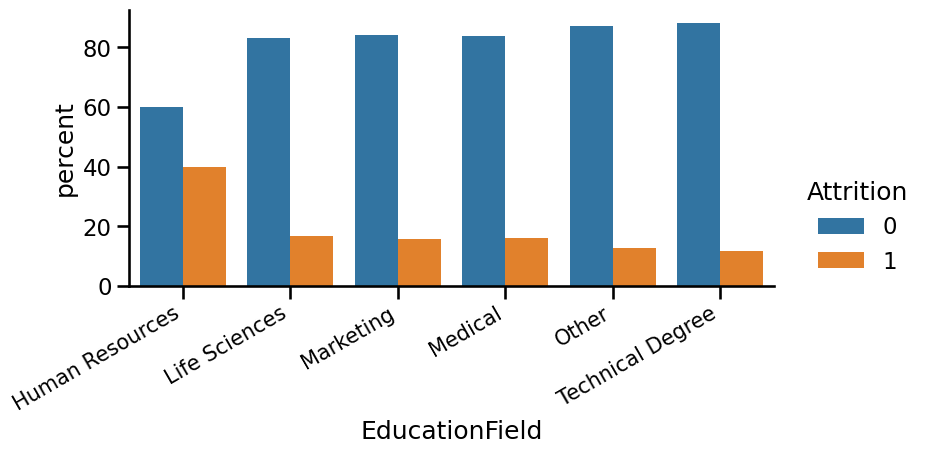

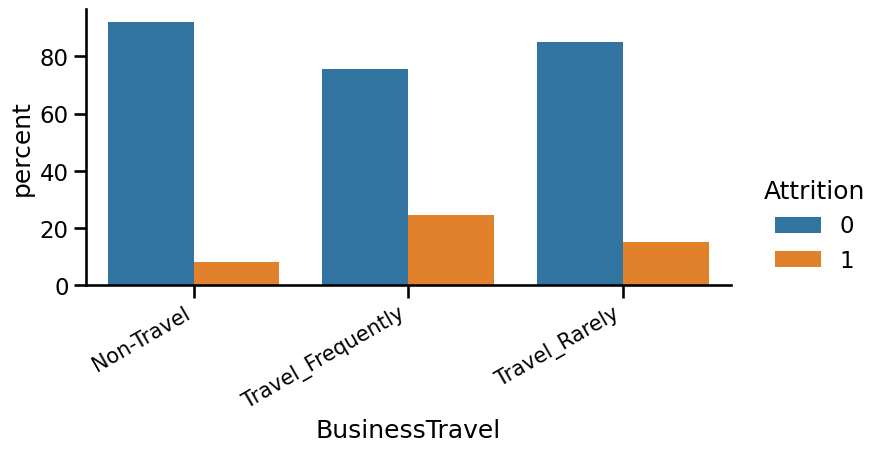

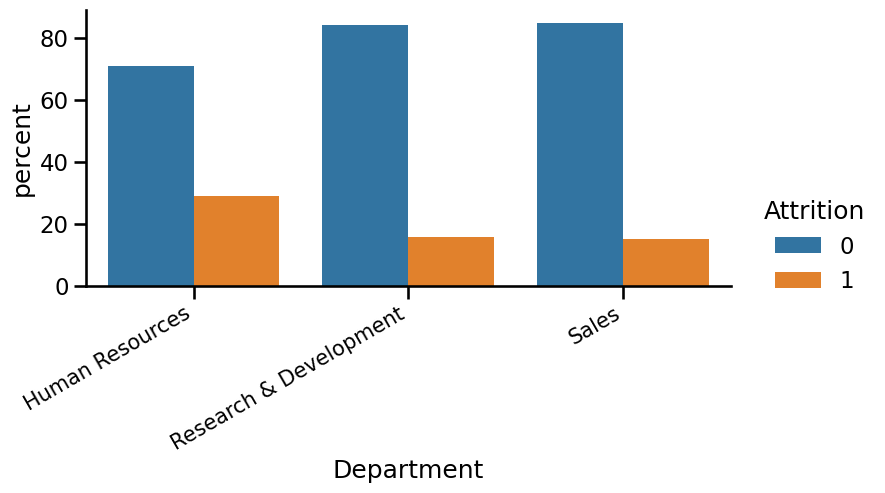

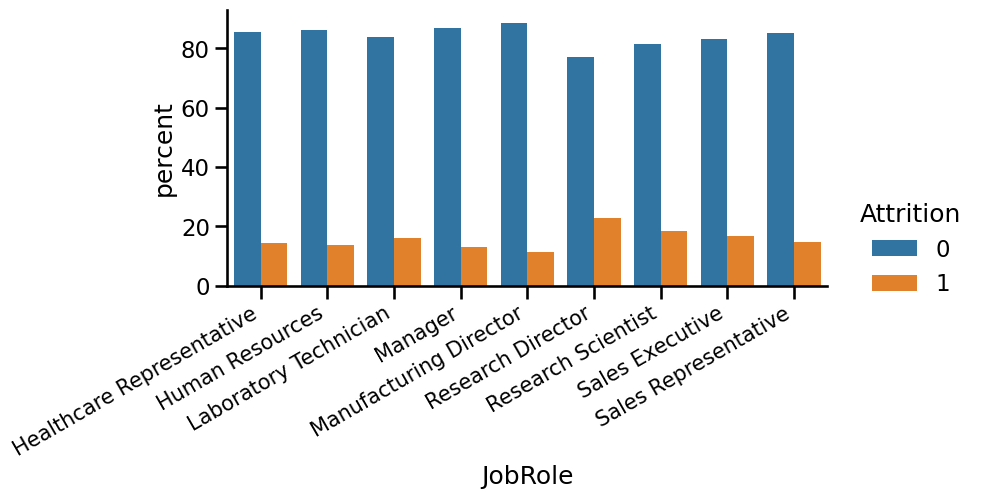

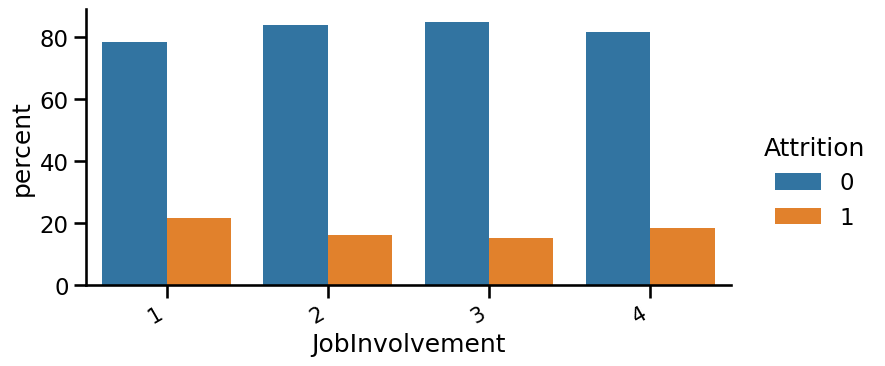

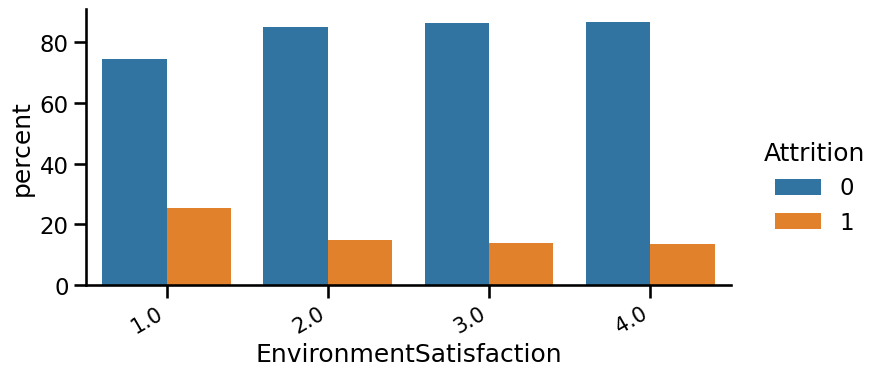

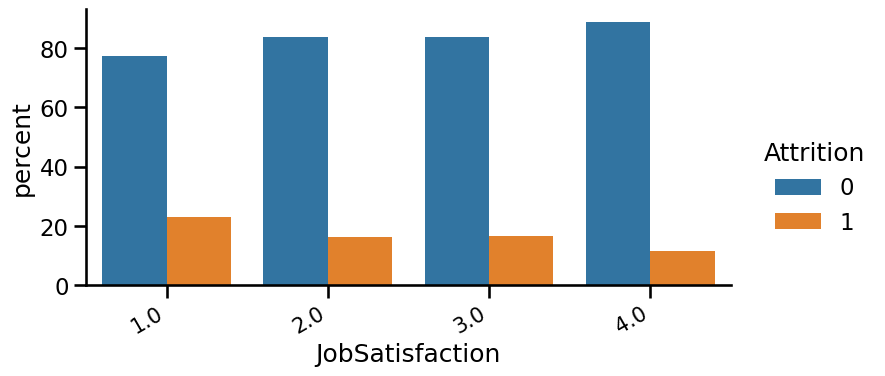

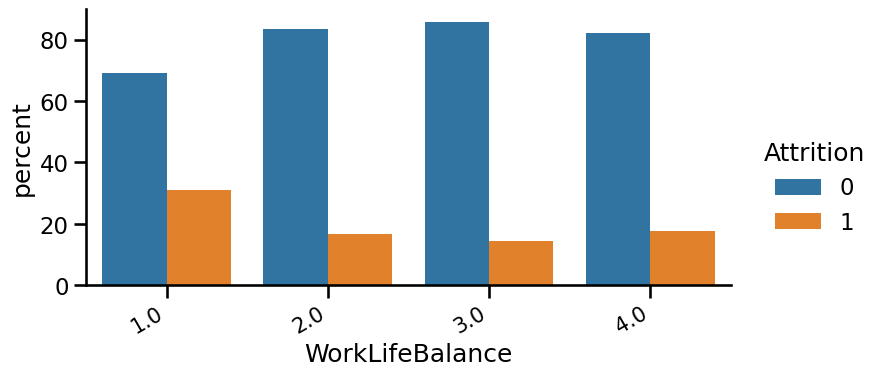

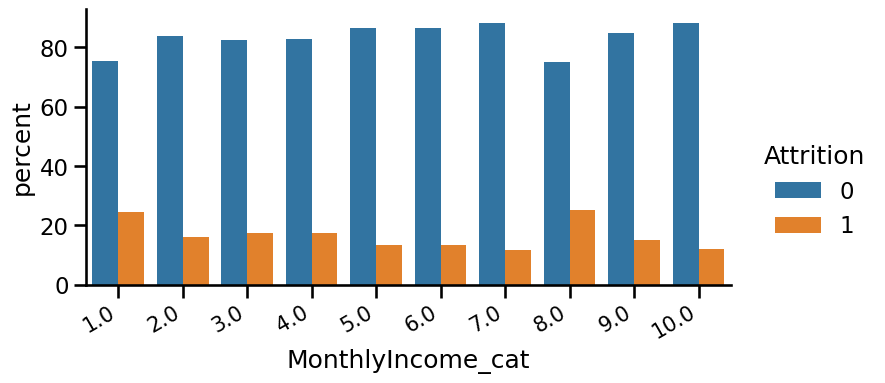

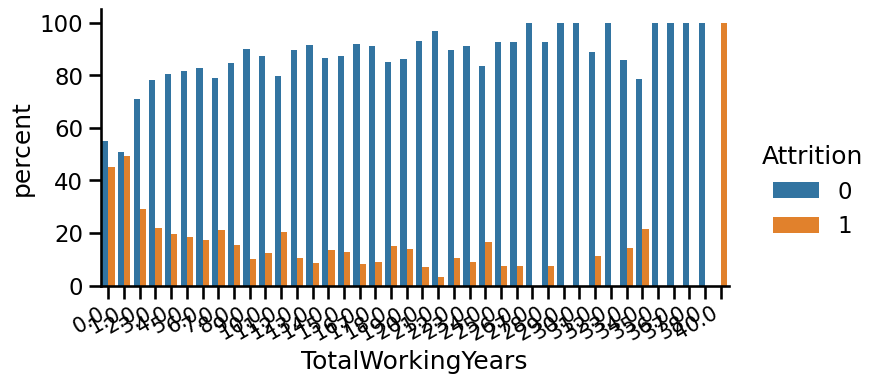

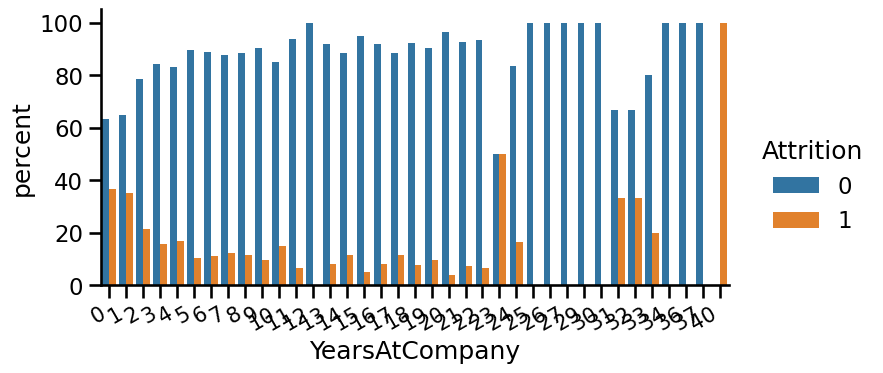

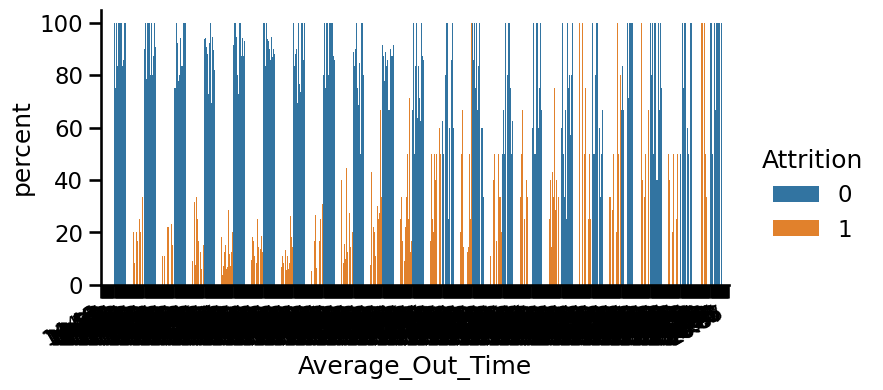

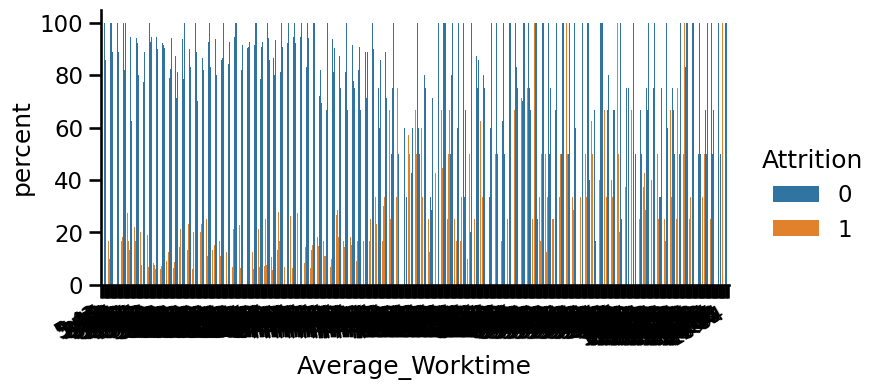

In [38]:
cols = ['EducationField', 'BusinessTravel', 'Department', 'JobRole', 'JobInvolvement', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'MonthlyIncome_cat', 'TotalWorkingYears', 'YearsAtCompany', 'Average_Out_Time', 'Average_Worktime']
for col in cols:
    plot_hist(col, Dataset)

In [ ]:
for name in cont:
    sbn.displot(data=Dataset, x=name, hue="Attrition", multiple="stack", kde=True, bins=25)
    plt.show()

# <font color='red'>10. Pipeline de transformation</font>

Le pipeline de transformation est une séquence d'étapes qui permettent de transformer les données d'entrée pour qu'elles soient prêtes à être utilisées pour l'entraînement d'un modèle. Dans ce cas-ci, le pipeline est composé de quatre étapes.
<br>
Le pipeline de transformation est constitué de quatre étapes:

- La première étape est réalisée par la classe `EthicColumnsRemover` qui hérite des classes `BaseEstimator` et `TransformerMixin`. Cette étape consiste à supprimer les colonnes éthiquement discutables tels que *"Age"*, *"Gender"* et *"MaritalStatus"*. D'autre données inutile possédant la même donnée :*"Over18"*, *"EmployeeCount"* *"StandardHours"*.

- La deuxième étape est réalisée par le transformateur `OneHotEncoder` qui convertit les variables catégorielles en variables numériques binaires. L'argument sparse=False est utilisé pour que le transformateur renvoie une matrice dense plutôt qu'une matrice creuse.

- La troisième étape est réalisée par la classe `StandardScaler` qui centre et réduit les variables numériques pour qu'elles aient une moyenne nulle et une variance unitaire.

Le pipeline de transformation est ensuite appliqué sur le jeu de données **general_data** en utilisant la méthode `fit_transform()` pour ajuster les paramètres des transformateurs et transformer les données d'entrée en données transformées. Les données transformées sont stockées dans la variable `transformed_data`.

In [24]:
from sklearn.base import TransformerMixin, BaseEstimator

class EthicColumnsRemover(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy.drop("Age", axis=1, inplace=True) 
        X_copy.drop("Gender", axis=1, inplace=True)
        X_copy.drop("MaritalStatus", axis=1, inplace=True)
        X_copy.drop("Over18", axis=1, inplace=True)
        X_copy.drop("EmployeeCount", axis=1, inplace=True)
        X_copy.drop("StandardHours", axis=1, inplace=True)
        return X_copy.values

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

dataset_pipeline = Pipeline([
    ('removeEthicColumns', EthicColumnsRemover()),
    ('onehot_encoder', OneHotEncoder(sparse=False)),
    ('scaler', StandardScaler())
])

transformed_data = dataset_pipeline.fit_transform(general_data)
transformed_data


c:\Users\oscar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[ 0.4384223 , -0.4384223 , -0.33709993, ..., -0.05842062,
        -0.03691067, -0.06917145],
       [-2.28090588,  2.28090588, -0.33709993, ..., -0.05842062,
        -0.03691067, -0.06917145],
       [ 0.4384223 , -0.4384223 , -0.33709993, ..., -0.05842062,
        -0.03691067, -0.06917145],
       ...,
       [ 0.4384223 , -0.4384223 , -0.33709993, ..., -0.05842062,
        -0.03691067, -0.06917145],
       [ 0.4384223 , -0.4384223 , -0.33709993, ..., -0.05842062,
        -0.03691067, -0.06917145],
       [ 0.4384223 , -0.4384223 , -0.33709993, ..., -0.05842062,
        -0.03691067, -0.06917145]])